In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt

In [4]:
# Load Data
X_train_path = "/content/X_train.csv"
X_test_path  = "/content/X_test.csv"
y_train_path = "/content/y_train.csv"
y_test_path  = "/content/y_test.csv"

X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

print("Raw shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

Raw shapes:
X_train: (80000, 400)
X_test : (20000, 400)
y_train: (80000, 1)
y_test : (20000, 1)


In [5]:
# Prepare data for RF
# X: keep as 2D (n_samples, n_features)
if isinstance(X_train, pd.DataFrame):
    X_train_rf = X_train.values
    X_test_rf  = X_test.values
else:
    X_train_rf = X_train
    X_test_rf  = X_test

# y: flatten (n_samples, 1) -> (n_samples,)
if isinstance(y_train, pd.DataFrame):
    y_train_rf = y_train.values.reshape(-1)
else:
    y_train_rf = y_train.reshape(-1)

if isinstance(y_test, pd.DataFrame):
    y_test_rf = y_test.values.reshape(-1)
else:
    y_test_rf = y_test.reshape(-1)

print("After conversion:")
print("X_train_rf:", X_train_rf.shape)
print("X_test_rf :", X_test_rf.shape)
print("y_train_rf:", y_train_rf.shape)
print("y_test_rf :", y_test_rf.shape)

After conversion:
X_train_rf: (80000, 400)
X_test_rf : (20000, 400)
y_train_rf: (80000,)
y_test_rf : (20000,)


In [6]:
# Train RF
rf_model = RandomForestClassifier(
    n_estimators=300, # number of trees
    max_depth=None, # let trees grow fully (can tune this)
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    class_weight=None
)

rf_model.fit(X_train_rf, y_train_rf)

print("Random Forest training complete.")

Random Forest training complete.


In [7]:
# Accuracy, Confusion Matrix, Classification Report

# Predict class probabilities for test set
y_proba = rf_model.predict_proba(X_test_rf)[:, 1]

# Choose threshold (0.5 by default)
threshold = 0.5
y_pred = (y_proba > threshold).astype(int)

# Accuracy
rf_accuracy = accuracy_score(y_test_rf, y_pred)
print(f"Random Forest Accuracy (threshold={threshold}): {rf_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_rf, y_pred))

Random Forest Accuracy (threshold=0.5): 0.5426

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52      9829
           1       0.55      0.59      0.57     10171

    accuracy                           0.54     20000
   macro avg       0.54      0.54      0.54     20000
weighted avg       0.54      0.54      0.54     20000

Confusion Matrix:
[[4874 4955]
 [4192 5979]]


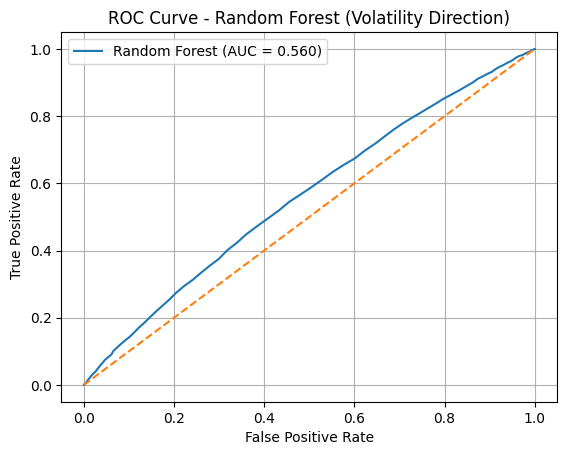

ROC AUC: 0.5598


In [8]:
# ROC & AUC
fpr, tpr, _ = roc_curve(y_test_rf, y_proba)
auc = roc_auc_score(y_test_rf, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Volatility Direction)")
plt.legend()
plt.grid(True)
plt.show()

print(f"ROC AUC: {auc:.4f}")

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 3, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1
)

grid.fit(X_train_rf, y_train_rf)

print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

# Evaluate best model on test set
best_rf = grid.best_estimator_
y_proba_best = best_rf.predict_proba(X_test_rf)[:, 1]
auc_best = roc_auc_score(y_test_rf, y_proba_best)
print("Test AUC (best RF):", auc_best)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 300}
Best CV AUC: 0.5642271627298473
Test AUC (best RF): 0.5692395813459814
